# **Seminar: Politische Debatten & Polarisierung im Bundestag**
## Sentimentanalyse im Kontext von Corona

## 1. Packages installieren

In [6]:
# Import Basic Packagesw
import numpy as np                 # Numpy
import pandas as pd                 #Datafrane

# Import Visualization Packages
from collections import Counter     # um worte zu zählen
#import matplotlib.pyplot as plt   # Für Visualisierung
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator #Wordcloud erstellen
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp


# Import NLP Packages
import nltk
pd.options.mode.chained_assignment = None
import spacy

# Methoden aus anderem Modul importieren
import Sentiment_Methods

## 2. Datensatz vorbereiten

### Datensatz einlesen

In [8]:
# df Legislaturperiode 2019 (24.10.2017-26.09.21)
df19 = pd.read_json(r"C:\Users\paula\OneDrive\Uni\2. Lernpools Master\3. Semester\Soziologie\Data_Speeches\speeches_19.jsonl", lines=True)
df19['date'] = pd.to_datetime(df19['date'])
df19.sort_values(by='date')


# df Legislaturperiode 2020 (24.10.2017-26.09.21)
df20 = pd.read_json(r"C:\Users\paula\OneDrive\Uni\2. Lernpools Master\3. Semester\Soziologie\Data_Speeches\speeches_20.jsonl", lines=True)
df20['date'] = pd.to_datetime(df20['date'])
df20.sort_values(by='date')


,text,id,period,date,name,party,redner_id,discussion_title
8620,"Frau Präsidentin, ich nehme die Wahl an und fr...",ID20101400,18,2021-10-26,Petra Pau,DIE LINKE,11003206,Tagesordnungspunkt 6 2021-10-26
8607,Sehr geehrter Herr Alterspräsident! So muss ic...,ID20100100,18,2021-10-26,Gabriele Katzmarek,SPD,11004325,Tagesordnungspunkt 2 2021-10-26
8608,Herr Präsident! Liebe Kolleginnen und Kollegen...,ID20100200,18,2021-10-26,Stefan Müller,CDU/CSU,11003597,Tagesordnungspunkt 2 2021-10-26
8609,Sehr geehrter Herr Alterspräsident Wolfgang Sc...,ID20100300,18,2021-10-26,Britta Haßelmann,BÜNDNIS 90/DIE GRÜNEN,11003764,Tagesordnungspunkt 2 2021-10-26
8610,Sehr geehrter Herr Präsident! Meine lieben Kol...,ID20100400,18,2021-10-26,Marco Buschmann,FDP,11004023,Tagesordnungspunkt 2 2021-10-26
...,...,...,...,...,...,...,...,...
9145,Vielen Dank. – Frau Präsidentin! Meine sehr ve...,ID209804700,18,2023-04-21,Caren Lay,DIE LINKE,11004088,Tagesordnungspunkt 24 2023-04-21
9146,Sehr geehrte Frau Präsidentin! Werte Kolleginn...,ID209804800,18,2023-04-21,Daniel Föst,FDP,11004716,Tagesordnungspunkt 24 2023-04-21
9147,Sehr geehrte Frau Präsidentin! Liebe Kolleginn...,ID209804900,18,2023-04-21,Petra Nicolaisen,CDU/CSU,11004841,Tagesordnungspunkt 24 2023-04-21
9138,Frau Präsidentin! Herr Staatssekretär! Meine l...,ID209804000,18,2023-04-21,Mechthilde Wittmann,CDU/CSU,11005261,Tagesordnungspunkt 13 2023-04-21


In [9]:
# Im Nächsten Schritt filtern wir den Dataframe aus der 19 Periode auf die passenden Zeiträume, da wir nur die Reden im Zeitraum von Corona erhalten wollen 09.03.2020
start_date = pd.to_datetime('2020-02-25')
df19_filtered = df19[df19['date'] >= start_date]

In [10]:
# Festlegung der Keywords nach den gesucht werden soll
keywords = ['Covid-19']

# Aufruf der Methode, um die Reden zu erhalten, die entsprechende Keywords haben.
df19_Covid = Sentiment_Methods.filter_dataframe_by_keywords_with_synonyms(df19_filtered, keywords)

#
df20_Covid = Sentiment_Methods.filter_dataframe_by_keywords_with_synonyms(df20, keywords)

# Ausgabe der gefundenen Reden
df19_Covid.head(4)

,text,id,period,date,name,party,redner_id,discussion_title
523,Herr Präsident! Liebe Kolleginnen und Kollegen...,ID1919000100,19,2020-11-06,Jens Spahn,CDU/CSU,11003638,Tagesordnungspunkt 27 2020-11-06
524,Herr Präsident! Sehr geehrte Damen und Herren!...,ID1919000200,19,2020-11-06,Detlev Spangenberg,AfD,11004898,Tagesordnungspunkt 27 2020-11-06
528,Sehr geehrter Herr Präsident! Sehr geehrte Kol...,ID1919000600,19,2020-11-06,Manuela Rottmann,BÜNDNIS 90/DIE GRÜNEN,11004866,Tagesordnungspunkt 27 2020-11-06
544,Sehr geehrte Frau Präsidentin! Meine sehr geeh...,ID1919002200,19,2020-11-06,Gabriele Katzmarek,SPD,11004325,Tagesordnungspunkt 28 2020-11-06


In [43]:


import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return synonyms

def count_occurrences_of_keywords(df, keywords):
    def count_occurrences(text):
        word_tokens = word_tokenize(text.lower())
        keyword_occurrences = [1 for word in word_tokens if word in keywords]
        synonym_occurrences = [1 for word in word_tokens for keyword in keywords if word in get_synonyms(keyword)]
        return sum(keyword_occurrences) + sum(synonym_occurrences)
    
    df['occurrences'] = df['text'].apply(count_occurrences)
    return df


# List of keywords (including 'corona')
keywords = ['covid-19']

# Count occurrences of keywords and synonyms in each cell of 'text'
df_with_occurrences = count_occurrences_of_keywords(df20_Covid, keywords)

# Display the DataFrame with the occurrence count
print(df_with_occurrences)



                                                    text           id  period  \
1      Frau Präsidentin! Sehr geehrte Kolleginnen und...  ID203000200      18   
5      Ich beantworte angesichts der Zeit zunächst di...  ID203000600      18   
16     Frau Bundesministerin, neben den Krisen und He...  ID203001700      18   
25     Vielleicht zum ersten Teil Ihrer Frage bzw. An...  ID203002600      18   
27     Auch wenn Sie lauter fragen, ist es mein Recht...  ID203002800      18   
...                                                  ...          ...     ...   
10773  Sehr geehrte Frau Präsidentin! Liebe Kolleginn...  ID205507500      18   
10785  Vielen Dank. – Frau Präsidentin! Wenn deutsche...  ID205508700      18   
10787  Vielen Dank. – Sehr geehrte Frau Präsidentin! ...  ID205508900      18   
10788  Sehr geehrte Frau Präsidentin! Liebe Kolleginn...  ID205509000      18   
10790  Frau Präsidentin, ich freue mich sehr, Sie zu ...  ID205509200      18   

            date           

### Datensatz bearbeiten

In [11]:
#Methodenaufruf, indem df durch Satztokenisierung umgewandelt wird und in neuen df_grundrechte gespeichert wird: Jede Zeile enthält einen Satz
df19_Covid_Split = Sentiment_Methods.tokenize_and_split_sentences (df19_Covid)
df20_Covid_Split = Sentiment_Methods.tokenize_and_split_sentences (df20_Covid)

## Daten bereinigen

In [12]:
import nltk
nltk.download('stopwords')

#Festlegen einer eigenen Stoppwortliste
my_stopwords = ['ministerin', 'minister', 'kollege', 'kollegin', 'präsidentin', 'kolleginnen', 'kollegen', 'frau', 'herr', 'mann', 'geehrte', 'geehrter', 'liebe', 'lieber', 'damen', 'herren', 'präsident', 'vielen dank','dank','redner','rednerin']

#Methodenaufruf clean_text zur Textverarbeitung
df19_Covid_cleaned = Sentiment_Methods.clean_text(df19_Covid_Split, my_stopwords)
df19_Covid_cleaned.head(9)

df20_Covid_cleaned = Sentiment_Methods.clean_text(df20_Covid_Split, my_stopwords)
df20_Covid_cleaned.head(9)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paula\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,satz,id,period,date,name,party,redner_id,discussion_title,text,tokenized_text,tokens,cleaned_text
2,Die einrichtungsbezogene Impfpflicht mit der e...,ID203110500,18,2022-04-28,Kay-Uwe Ziegler,AfD,11005265,Tagesordnungspunkt 17 2022-04-28,Sehr geehrte Frau Präsidentin! Sehr geehrte Ko...,"[Sehr geehrte Frau Präsidentin!, Sehr geehrte ...","[einrichtungsbezogene, Impfpflicht, erklärten,...",einrichtungsbezogene Impfpflicht erklärten Zie...
3,In der gestrigen Sitzung des Gesundheitsaussch...,ID203110500,18,2022-04-28,Kay-Uwe Ziegler,AfD,11005265,Tagesordnungspunkt 17 2022-04-28,Sehr geehrte Frau Präsidentin! Sehr geehrte Ko...,"[Sehr geehrte Frau Präsidentin!, Sehr geehrte ...","[gestrigen, Sitzung, Gesundheitsausschusses, s...",gestrigen Sitzung Gesundheitsausschusses stell...
4,Vom Ministerium und vom RKI gab es nur ein gan...,ID203110500,18,2022-04-28,Kay-Uwe Ziegler,AfD,11005265,Tagesordnungspunkt 17 2022-04-28,Sehr geehrte Frau Präsidentin! Sehr geehrte Ko...,"[Sehr geehrte Frau Präsidentin!, Sehr geehrte ...","[Ministerium, RKI, gab, ganz, kurzes, Nein, An...",Ministerium RKI gab ganz kurzes Nein Antwort
5,Vom Paul-Ehrlich-Institut erhielt ich überhaup...,ID203110500,18,2022-04-28,Kay-Uwe Ziegler,AfD,11005265,Tagesordnungspunkt 17 2022-04-28,Sehr geehrte Frau Präsidentin! Sehr geehrte Ko...,"[Sehr geehrte Frau Präsidentin!, Sehr geehrte ...","[Paul-Ehrlich-Institut, erhielt, überhaupt, An...",Paul-Ehrlich-Institut erhielt überhaupt Antwort
6,Professor Wieler äußerte in der nächsten Runde...,ID203110500,18,2022-04-28,Kay-Uwe Ziegler,AfD,11005265,Tagesordnungspunkt 17 2022-04-28,Sehr geehrte Frau Präsidentin! Sehr geehrte Ko...,"[Sehr geehrte Frau Präsidentin!, Sehr geehrte ...","[Professor, Wieler, äußerte, nächsten, Runde, ...",Professor Wieler äußerte nächsten Runde Satz g...
7,Eine Modellierung?,ID203110500,18,2022-04-28,Kay-Uwe Ziegler,AfD,11005265,Tagesordnungspunkt 17 2022-04-28,Sehr geehrte Frau Präsidentin! Sehr geehrte Ko...,"[Sehr geehrte Frau Präsidentin!, Sehr geehrte ...",[Modellierung],Modellierung
8,Da draußen gibt es doch echte Menschen in den ...,ID203110500,18,2022-04-28,Kay-Uwe Ziegler,AfD,11005265,Tagesordnungspunkt 17 2022-04-28,Sehr geehrte Frau Präsidentin! Sehr geehrte Ko...,"[Sehr geehrte Frau Präsidentin!, Sehr geehrte ...","[draußen, gibt, echte, Menschen, medizinischen...",draußen gibt echte Menschen medizinischen Beru...
9,"Deshalb müsste es doch möglich sein, dass in V...",ID203110500,18,2022-04-28,Kay-Uwe Ziegler,AfD,11005265,Tagesordnungspunkt 17 2022-04-28,Sehr geehrte Frau Präsidentin! Sehr geehrte Ko...,"[Sehr geehrte Frau Präsidentin!, Sehr geehrte ...","[Deshalb, müsste, möglich, Vorbereitung, Geset...",Deshalb müsste möglich Vorbereitung Gesetzes e...
10,Sie ahnen es vielleicht schon: Diesen wissensc...,ID203110500,18,2022-04-28,Kay-Uwe Ziegler,AfD,11005265,Tagesordnungspunkt 17 2022-04-28,Sehr geehrte Frau Präsidentin! Sehr geehrte Ko...,"[Sehr geehrte Frau Präsidentin!, Sehr geehrte ...","[ahnen, vielleicht, schon, wissenschaftlichen,...",ahnen vielleicht schon wissenschaftlichen Nach...


## 4. Deskriptive Datenanalyse

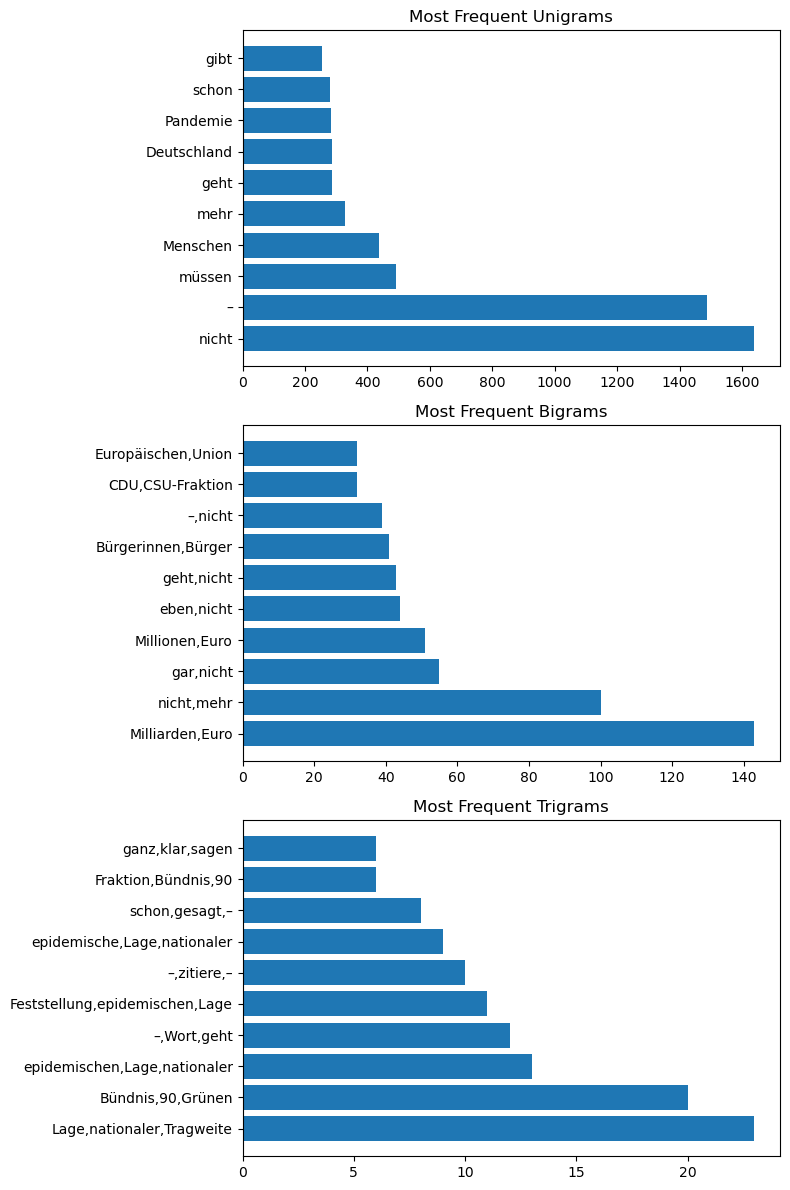

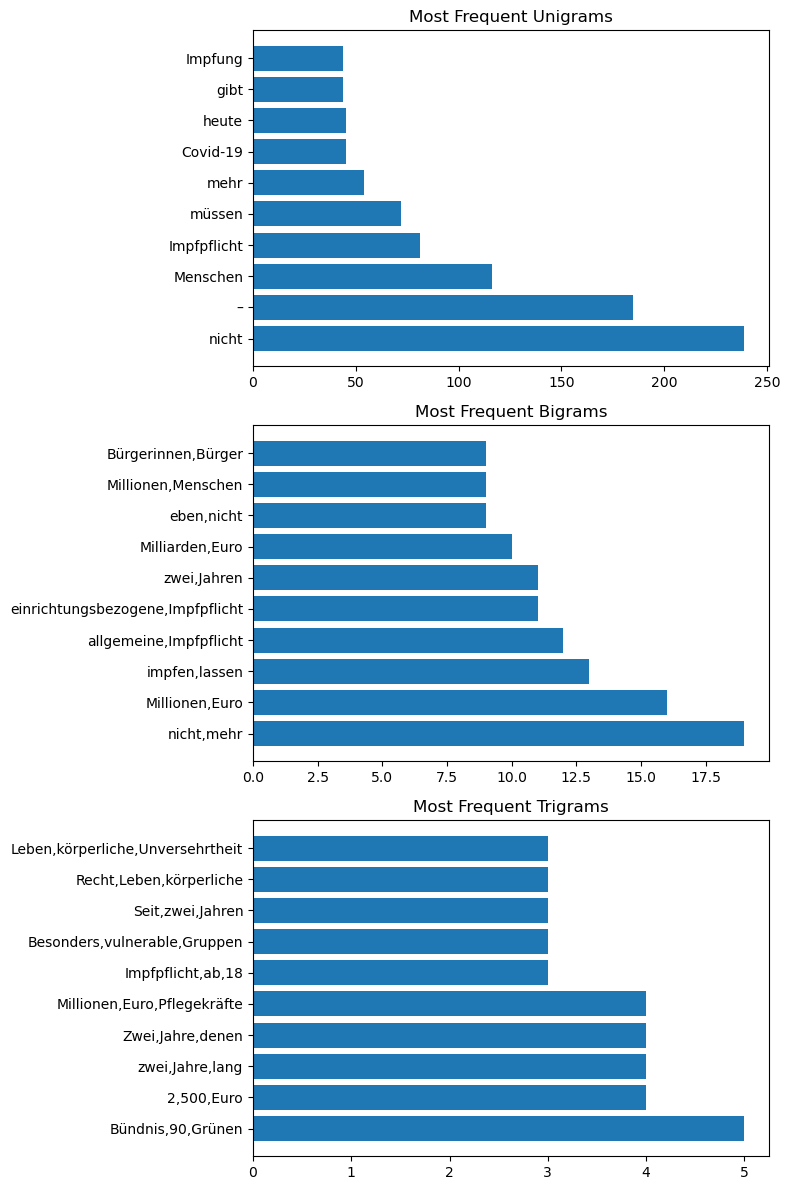

In [14]:
#Ausgabe der nGrams, um Stopwortliste zu überarbeiten
ngram_Stoppwortliste19 = Sentiment_Methods.plot_most_frequent_ngrams (df19_Covid_cleaned)
ngram_Stoppwortliste20 = Sentiment_Methods.plot_most_frequent_ngrams (df20_Covid_cleaned)

## 5. Sentimentanalyse

### Modellentwicklung

In [33]:
#Wir beginnen mit dem Methodenaufruf, um unsere Sentiment Modell german-bert anzuwenden, dieses werden wir auf dem cleaned text und dem original text anwenden 
import torchvision

#Original Text - Modell Periode 19
modell_original19 = Sentiment_Methods.sentiment_analysis(df19_Covid_cleaned, 'satz')
modell_original19.head (15)
#modell_original19.to_csv('modellorginal19.csv')

#Original Text - Modell Periode 19
modell_original20 = Sentiment_Methods.sentiment_analysis(df20_Covid_cleaned, 'satz')
modell_original20.head (15)
#modell_original20.to_csv('modellorginal20.csv')

KeyboardInterrupt: 

In [19]:
#Modellaufruf mit preprocessed Text Periode 19
modell_processed19 = Sentiment_Methods.sentiment_analysis(df19_Covid_cleaned, 'cleaned_text')
modell_processed19.head (15)
#modell_processed19.to_csv('modell_processed19.csv')

#Modellaufruf mit preprocessed Text Periode 20
modell_processed20 = Sentiment_Methods.sentiment_analysis(df20_Covid_cleaned, 'cleaned_text')
modell_processed20.head (15)
#modell_processed20.to_csv('modell_processed20.csv')


### Packages für Sentimentanalyse

In [27]:
Sentiment_Methods.plot_sentiment_analysis(modell_original19, modell_processed19)


In [32]:
Sentiment_Methods.plot_sentiment_wordclouds (modell_cleaned19)
Sentiment_Methods.plot_sentiment_wordclouds (modell_processed19)

NameError: name 'modell_cleaned19' is not defined